In [1]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
import calendar
import json
import csv
import numpy as np
from selenium import webdriver
import time
import math
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

## Data Preparation

We will only keep the columns that we need.

In [2]:
gas_stations = pd.read_csv('Gas_Stations_03_28.csv')
gas_stations['Franchise (or private)'] = gas_stations['Franchise (or private)'].replace('Mobil Gáz', 'Magán')

In [3]:
gas_stations = gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway','95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Cng', 'Prémium Gázolaj', 'Prémium Benzin E10','98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő','Ccs - Elektromos Töltő', 'Number of competition 1km','Number of competition 5km',
                            'Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']]

gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']] = gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']].astype('category')

radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
gas_stations[radius] = gas_stations[radius].astype('int')

## City Attribute:

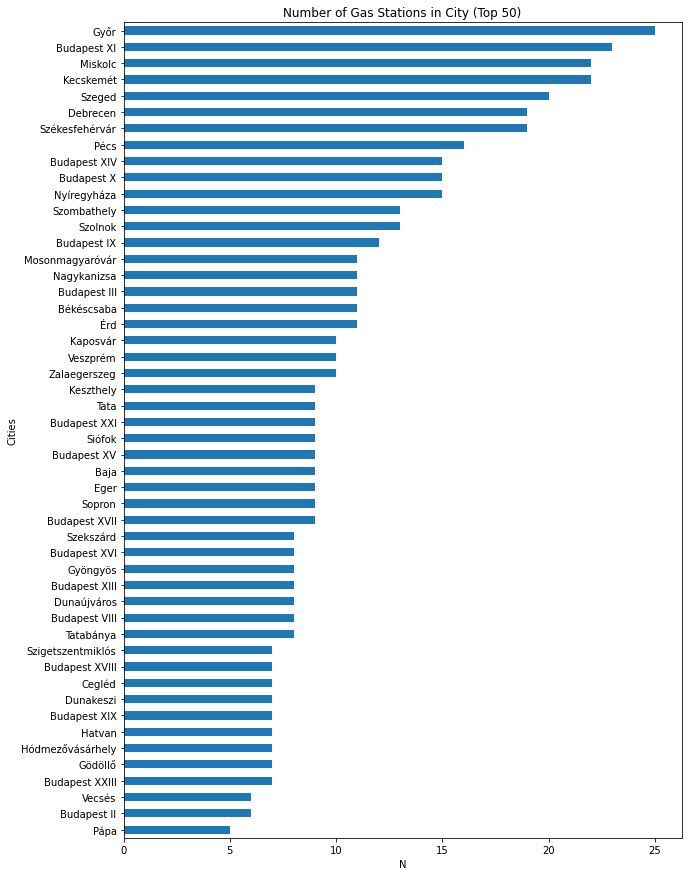

In [4]:
counts = gas_stations['City'].value_counts()[:50].sort_values(ascending = True)

plt.figure(figsize=(10, 15))
counts.plot(kind='barh')

plt.title('Number of Gas Stations in City (Top 50)')
plt.xlabel('N')
plt.ylabel('Cities')
plt.show()

We would like to check the relationship between the **City and Franchise** attribute. For independence we use Chi Squared test.

In [5]:
# Create a contingency table
cont_table = pd.crosstab(gas_stations['City'], gas_stations['Franchise (or private)'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for City and Franchise: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for City and Franchise: 3657.8629274539476
P-value: 0.0012011102447612128


In this case, the chi-square statistic of 3657.86 is relatively large, and the small p-value of 0.0012 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between City and Franchise (or private) status of gas stations

**City (and highway) and Gas Prices**: We will group by cities (and highway) and calculate the average prices. We should check where the best and worst prices are.

In [6]:
from IPython.display import display, HTML

gas_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg',
             '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
             '98-As Benzin E5']

# create HTML and CSS for grid layout
html = "<style>.container { display: grid; grid-template-columns: repeat(5, 1fr); grid-gap: 20px; } </style>"
html += "<div class='container'>"

# loop through gas types and display top and worst 5 prices in a dataframe
for gas in gas_types:
    top_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values()[:5].to_frame()
    worst_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values(ascending = False)[:5].to_frame()
    
    # create HTML for each dataframe
    top_html = f"<h3>Top 5 Prices for {gas}</h3>{top_5.to_html()}"
    worst_html = f"<h3>Worst 5 Prices for {gas}</h3>{worst_5.to_html()}"
    
    # add HTML for each dataframe to the grid
    if gas == gas_types[-1]:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"
    else:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"

html += "</div>"

# display the grid
display(HTML(html))

,,95-ös Benzin E10
City,Highway,
Sóskút,0,578.0
Zsana,0,580.0
Kocs,0,584.0
Földes,0,584.9
Herceghalom,0,585.0
,,95-ös Benzin E10
City,Highway,
Akasztó,0,647.0
Tata,1,639.9


## Franchise variable
We already checked the relationship between the City and Franchise variable.

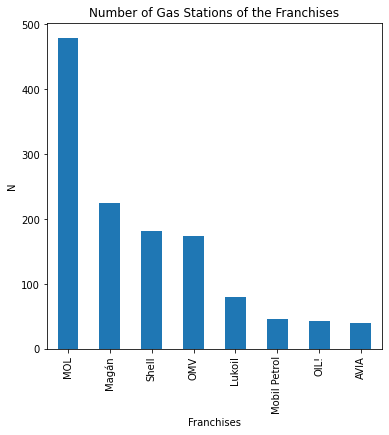

In [7]:
counts = gas_stations['Franchise (or private)'].value_counts()
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')

plt.title('Number of Gas Stations of the Franchises')
plt.xlabel('Franchises')
plt.ylabel('N')
plt.show()

Next we should check the relationship between the Franchise and Highway attribute. We will use the same chi squared test.

In [8]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['Highway'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and Highway: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and Highway: 42.84128415553539
P-value: 3.579460471015146e-07


This means that there is a significant association between the franchise and highway attribute.

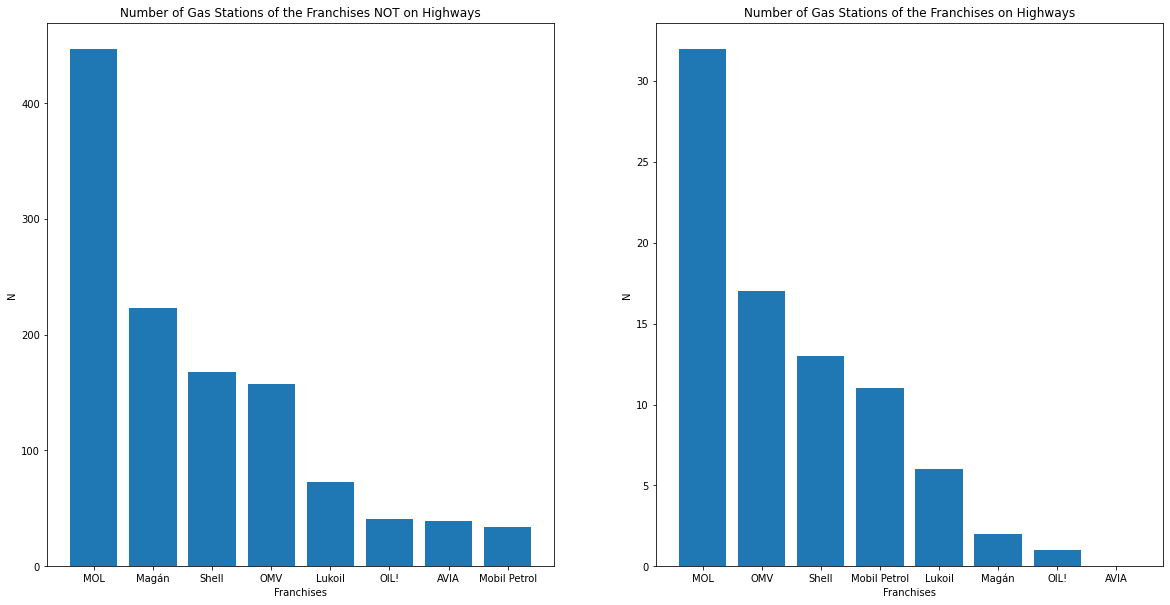

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first graph on the left subplot
not_on_highway = gas_stations.loc[gas_stations['Highway'] == 0]
counts_not = not_on_highway['Franchise (or private)'].value_counts()
axs[0].bar(counts_not.index, counts_not.values)
axs[0].set_title('Number of Gas Stations of the Franchises NOT on Highways')
axs[0].set_xlabel('Franchises')
axs[0].set_ylabel('N')

# Plot the second graph on the right subplot
on_highway = gas_stations.loc[gas_stations['Highway'] == 1]
counts = on_highway['Franchise (or private)'].value_counts()
axs[1].bar(counts.index, counts.values)
axs[1].set_title('Number of Gas Stations of the Franchises on Highways')
axs[1].set_xlabel('Franchises')
axs[1].set_ylabel('N')

# Show the plot
plt.show()

The average Price based on Franchise:

In [10]:
gas_stations.groupby(['Franchise (or private)'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,600.700000,609.952941,371.750000,636.533333,647.511111,NaN,NaN,578.500000
Lukoil,605.569620,605.569620,361.333333,636.464286,649.319149,NaN,NaN,NaN
MOL,607.125482,607.226882,354.760000,644.430679,662.353211,636.000000,NaN,604.500000
Magán,595.704225,598.095238,351.662963,634.730909,639.867308,628.087500,628.434783,501.547619
Mobil Petrol,598.188889,600.344444,349.047368,628.423810,639.328571,634.900000,NaN,599.000000
OIL!,599.046429,605.580000,376.760000,649.737500,625.966667,613.085714,684.450000,475.600000
OMV,609.703086,609.205488,404.823077,649.856329,664.332716,635.123684,NaN,536.600000
Shell,611.297790,607.988398,400.900000,686.072414,673.240000,667.060000,NaN,NaN


The average Price based on Franchise and Highway:

In [11]:
gas_stations.groupby(['Franchise (or private)', 'Highway'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

95-ös Benzin E10     Gázolaj         Lpg  \
Franchise (or private) Highway                                             
AVIA                   0              600.700000  609.952941  371.750000   
                       1                     NaN         NaN         NaN   
Lukoil                 0              604.000000  604.000000  356.000000   
                       1              624.666667  624.666667  380.000000   
MOL                    0              605.874943  605.978060  352.845304   
                       1              624.125000  624.125000  373.000000   
Magán                  0              595.624823  597.917931  351.662963   
                       1              606.900000  610.950000         NaN   
Mobil Petrol           0              592.929412  595.782353  349.064286   
                       1              614.445455  614.445455  349.000000   
OIL!                   0              599.046429  605.580000  376.760000   
                       1                     NaN         NaN         NaN   
OMV                    0              606.859310  606.955102  347.900000   
                       1              633.958824  628.664706  421.900000   
Shell                  0              609.084524  606.060714         NaN   
                       1              639.900000  632.900000  400.900000   

                                100-As Benzin E5  Prémium Gázolaj  \
Franchise (or private) Highway                                      
AVIA                   0              636.533333       647.511111   
                       1                     NaN              NaN   
Lukoil                 0              634.000000       646.000000   
                       1              657.000000       672.000000   
MOL                    0              643.078030       661.024752   
                       1              661.709677       679.125000   
Magán                  0              634.505556       639.435294   
                       1              646.900000       661.900000   
Mobil Petrol           0              622.738710       632.400000   
                       1              644.445455       654.445455   
OIL!                   0              649.737500       625.966667   
                       1                     NaN              NaN   
OMV                    0              646.879433       661.997241   
                       1              674.547059       684.252941   
Shell                  0              684.067702       670.900000   
                       1              710.900000       697.900000   

                                Prémium Benzin E10  98-As Benzin E5  \
Franchise (or private) Highway                                        
AVIA                   0                       NaN              NaN   
                       1                       NaN              NaN   
Lukoil                 0                       NaN              NaN   
                       1                       NaN              NaN   
MOL                    0                636.000000              NaN   
                       1                       NaN              NaN   
Magán                  0                627.542857       628.434783   
                       1                631.900000              NaN   
Mobil Petrol           0                       NaN              NaN   
                       1                634.900000              NaN   
OIL!                   0                613.085714       684.450000   
                       1                       NaN              NaN   
OMV                    0                631.900000              NaN   
                       1                660.723529              NaN   
Shell                  0                664.900000              NaN   
                       1                691.900000              NaN   

                                    Adblue  
Franchise (or private) Highway              
AVIA                   0        578.500000  
      

Franchises and their standard deviations:

In [12]:
gas_stations.groupby('Franchise (or private)')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,5.802528,10.735579,51.674462,5.480931,17.124138,NaN,NaN,95.081920
Lukoil,5.516138,5.516138,10.267023,7.313659,9.290262,NaN,NaN,NaN
MOL,6.491709,5.470322,8.431956,5.992763,5.108390,NaN,NaN,135.057395
Magán,7.911701,9.037815,35.257865,12.499406,17.967877,10.960766,7.102023,120.880863
Mobil Petrol,11.238372,17.704077,0.206474,11.500240,12.353341,0.000000,NaN,0.000000
OIL!,8.294152,16.429754,18.763875,33.172404,4.637169,8.844853,60.174787,96.086122
OMV,8.760275,7.039636,32.574176,8.890813,7.139722,9.178291,NaN,281.186184
Shell,8.304403,7.232867,NaN,7.365294,7.621790,7.354393,NaN,NaN


Next we should check out the average competitions of given radius of the franchises.

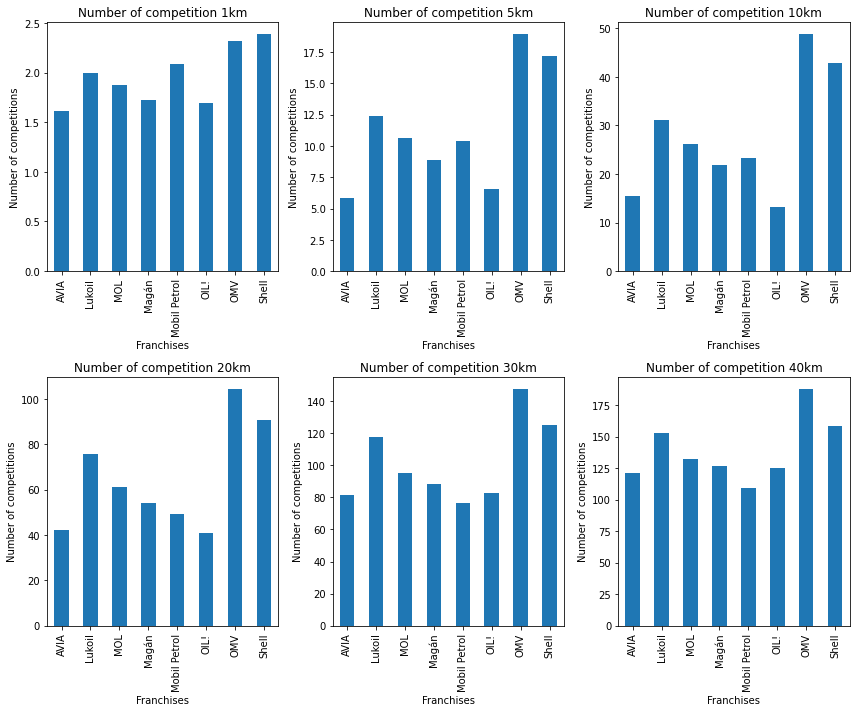

In [13]:
radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
mean_competitions = gas_stations.groupby('Franchise (or private)')[radius].mean()

# create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10))

# flatten the axes array for easier iteration
axes = axes.flatten()

# iterate over the columns and plot each one
for i, col in enumerate(mean_competitions.columns):
    ax = axes[i]
    mean_competitions[col].plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Franchises')
    ax.set_ylabel('Number of competitions')
    
# adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Highway Column

In [14]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,604.322692,604.596371,353.408468,649.599414,659.62801,645.624151,632.916,520.185000,89.0,94.0,89.0,NaN
1,627.272500,624.886420,383.894872,669.617722,679.12250,666.337500,NaN,600.909091,NaN,119.0,119.0,119.0


This clearly shows that the prices are higher next to Highways, also there is significant difference in standard deviations.

In [15]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,6.464807,6.694496,14.739519,18.143825,10.510654,17.325201,20.920518,118.696261,NaN,21.213203,NaN,NaN
1,10.363079,8.154274,24.675408,21.298572,13.811030,19.988606,NaN,6.331738,NaN,NaN,NaN,NaN


## 'Correlation' between the categorical variables:

Cramer's V is a measure of association between two categorical variables and ranges from 0 to 1, where 0 indicates no association and 1 indicates a strong association.

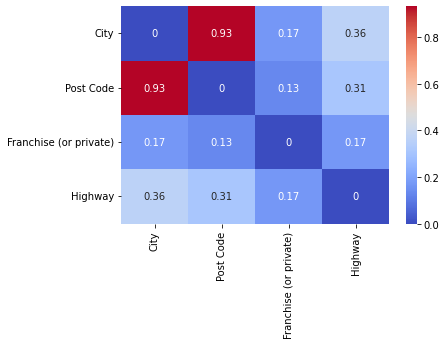

In [16]:
cat_val = gas_stations[['City', 'Post Code', 'Franchise (or private)', 'Highway']]

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corrected = r - ((r-1)**2)/(n-1)
    k_corrected = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corrected/min((k_corrected-1),(r_corrected-1)))

# create an empty correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(cat_val.columns), len(cat_val.columns))), columns=cat_val.columns, index=cat_val.columns)

# compute Cramer's V for each pair of columns
for i in range(len(cat_val.columns)):
    for j in range(i+1, len(cat_val.columns)):
        v = cramers_v(cat_val.iloc[:, i], cat_val.iloc[:, j])
        corr_matrix.iloc[i, j] = v
        corr_matrix.iloc[j, i] = v

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Correlation on Numerical Variables:

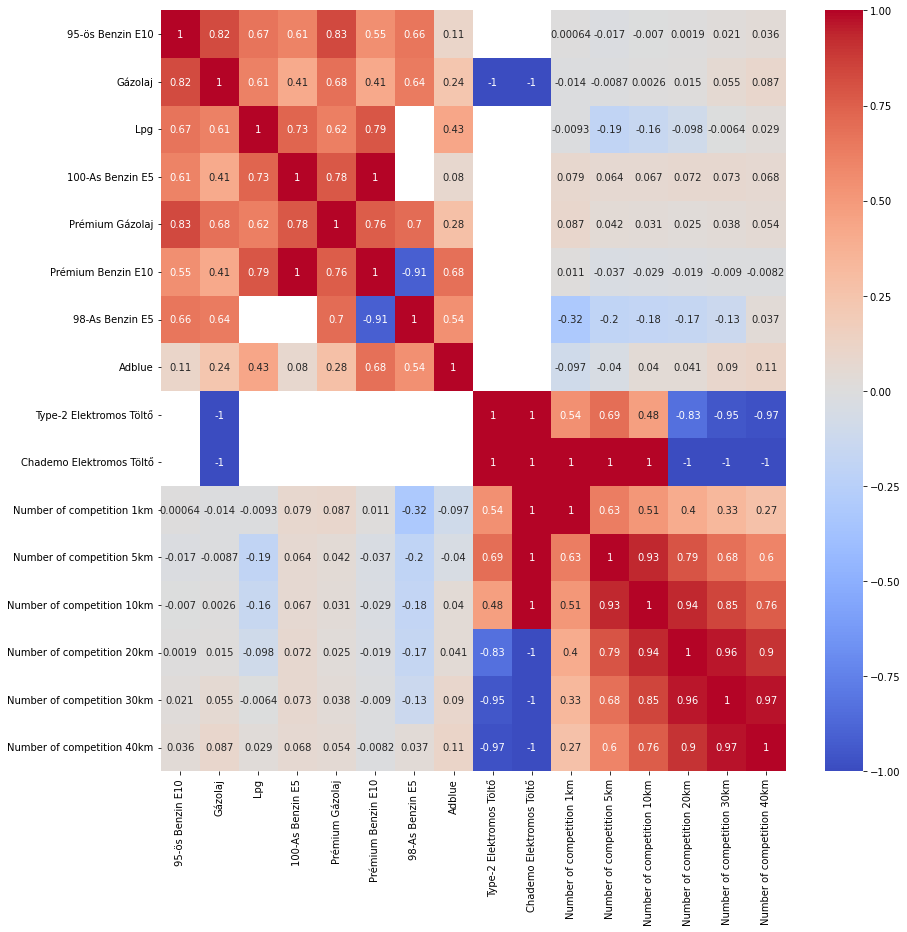

In [17]:
numerical = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
        'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő',
       'Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km']

float_val = gas_stations[numerical]
corr = float_val.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()


## Price Attributes:

In [18]:
prices = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
        'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő']

gas_stations[prices].describe()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-2 Elektromos Töltő,Chademo Elektromos Töltő
count,1120.000000,1128.000000,287.000000,932.000000,894.000000,297.000000,25.000000,91.000000,3.000000,2.000000
mean,605.961964,606.053369,357.551220,651.296245,661.372483,647.855892,632.916000,529.942857,102.333333,104.000000
std,9.019569,8.589484,19.443362,19.245559,12.184025,18.733453,20.920518,114.330506,20.816660,21.213203
min,569.000000,579.900000,320.000000,598.900000,605.000000,603.900000,605.000000,310.000000,79.000000,89.000000
25%,605.900000,605.900000,353.000000,643.000000,661.000000,631.900000,629.000000,439.950000,94.000000,96.500000
50%,606.000000,606.000000,353.000000,643.000000,661.000000,634.000000,629.000000,575.000000,109.000000,104.000000
75%,606.900000,606.000000,353.000000,651.175000,661.900000,664.900000,629.000000,599.000000,114.000000,111.500000
max,647.000000,689.900000,490.000000,728.000000,697.900000,691.900000,727.000000,860.000000,119.000000,119.000000


As we can see we have fresh data, since there are no 480 priced minimum.

## Number of competitions in radius:

Here we will check basic statistics about these attributes.

In [19]:
comp = ['Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km']
gas_stations[comp].describe()

,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,1.984968,12.238924,30.348892,69.357595,105.350475,142.650316
std,1.234473,16.334679,44.859534,90.238131,112.456335,123.643344
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,5.000000,16.000000,35.000000,57.000000
50%,2.000000,5.000000,11.000000,27.000000,47.000000,77.000000
75%,3.000000,15.250000,24.000000,41.250000,151.250000,305.000000
max,6.000000,72.000000,167.000000,273.000000,321.000000,379.000000


## Number of competitions and Gas Prices plots:

### 1 km radius competition price change:

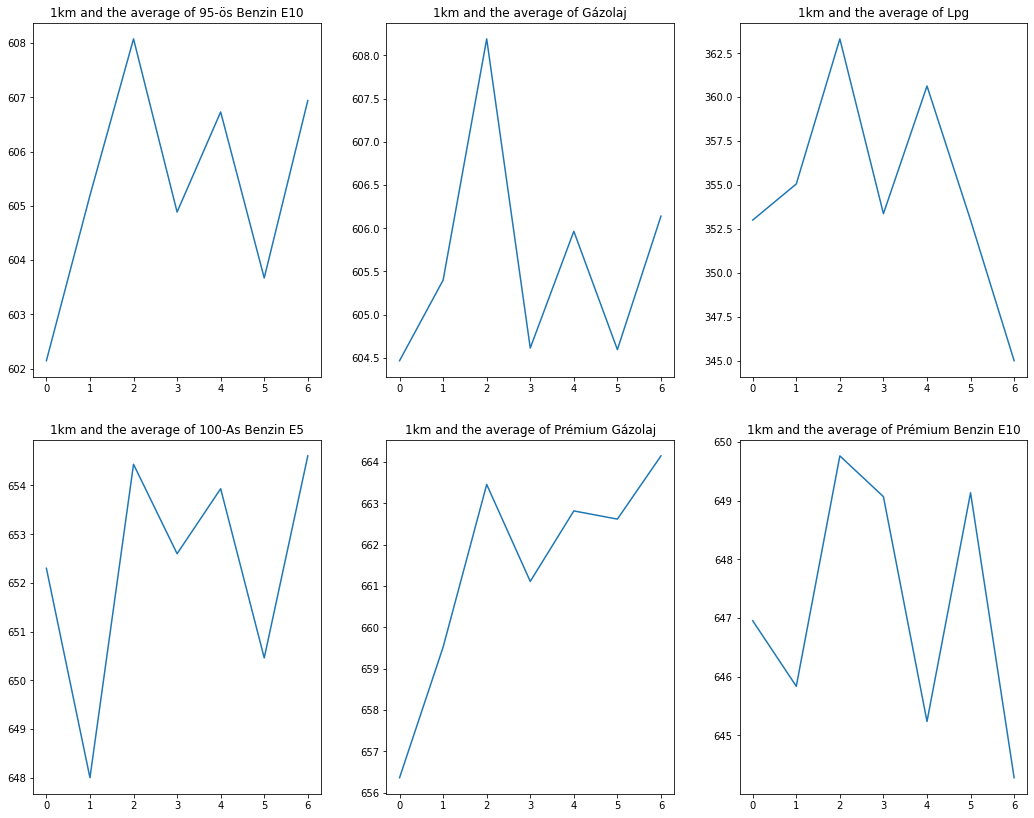

In [20]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']

fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']

fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[0]].sort_values().unique()
y1 = gas_stations.groupby(comp[0])[fuel_types[0]].mean()
y2 = gas_stations.groupby(comp[0])[fuel_types[1]].mean()
y3 = gas_stations.groupby(comp[0])[fuel_types[2]].mean()
y4 = gas_stations.groupby(comp[0])[fuel_types[3]].mean()
y5 = gas_stations.groupby(comp[0])[fuel_types[4]].mean()
y6 = gas_stations.groupby(comp[0])[fuel_types[5]].mean()

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 5 km radius competition price change:

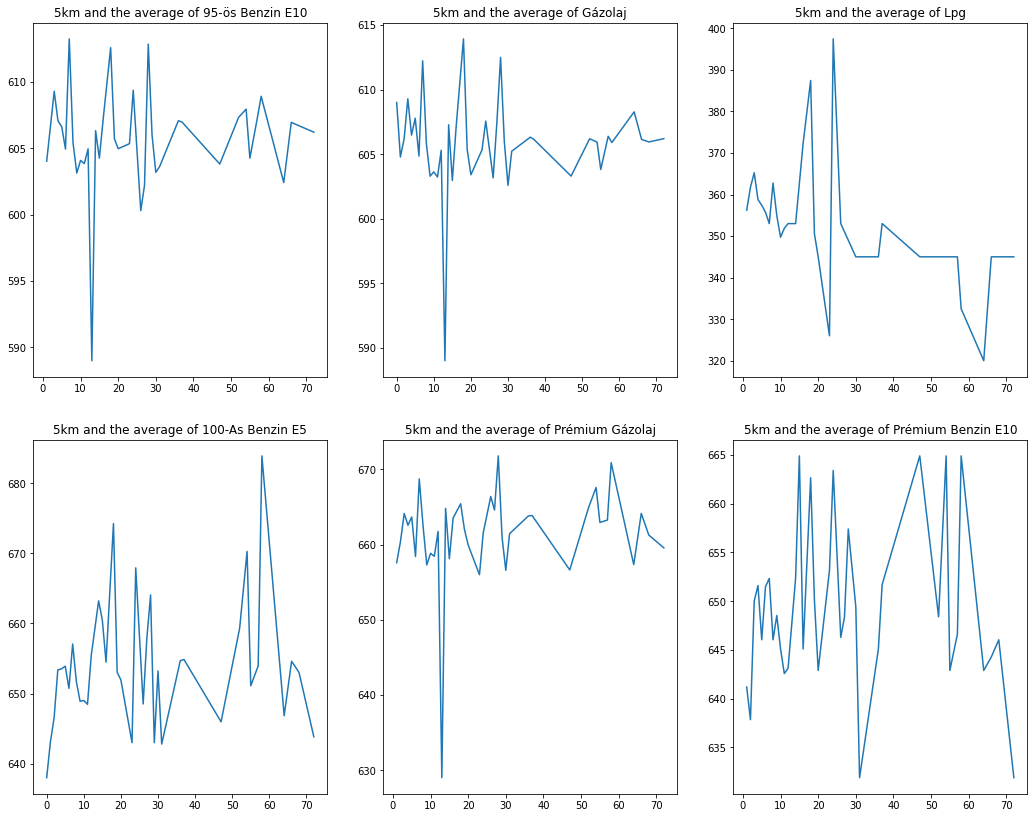

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[1]].sort_values().unique()
y1 = gas_stations.groupby(comp[1])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[1])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[1])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[1])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[1])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[1])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 10 km radius competition price change:

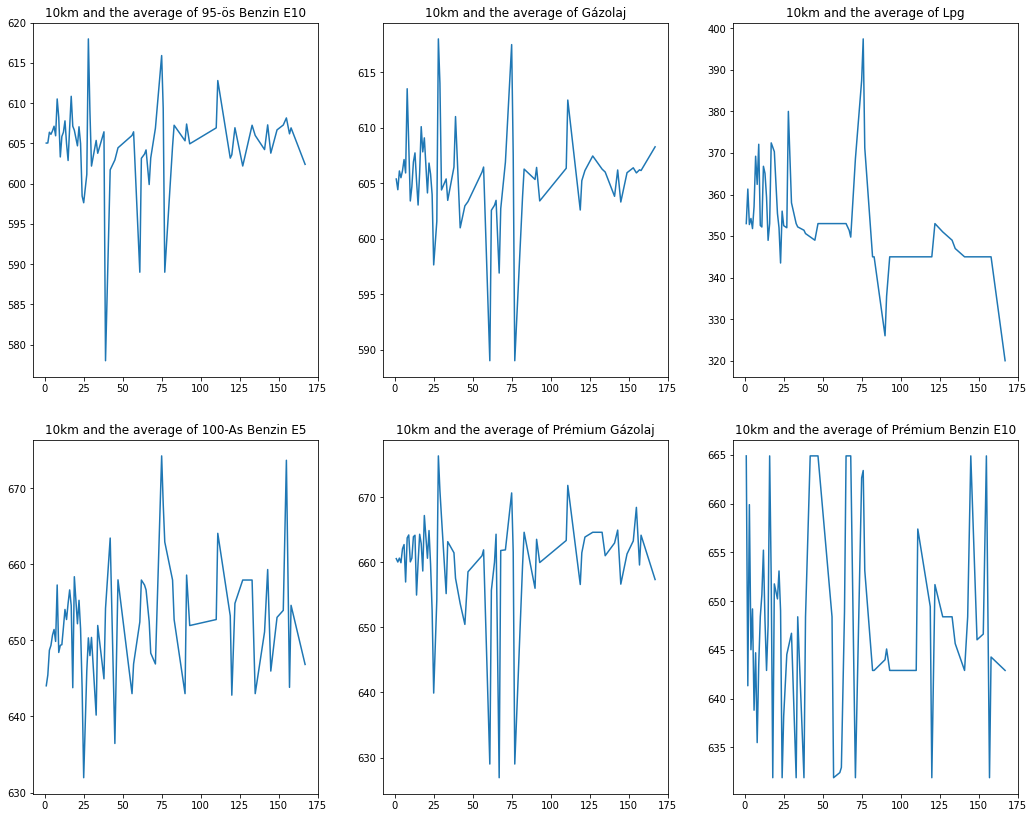

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[2]].sort_values().unique()
y1 = gas_stations.groupby(comp[2])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[2])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[2])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[2])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[2])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[2])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 20 km radius competition price change:

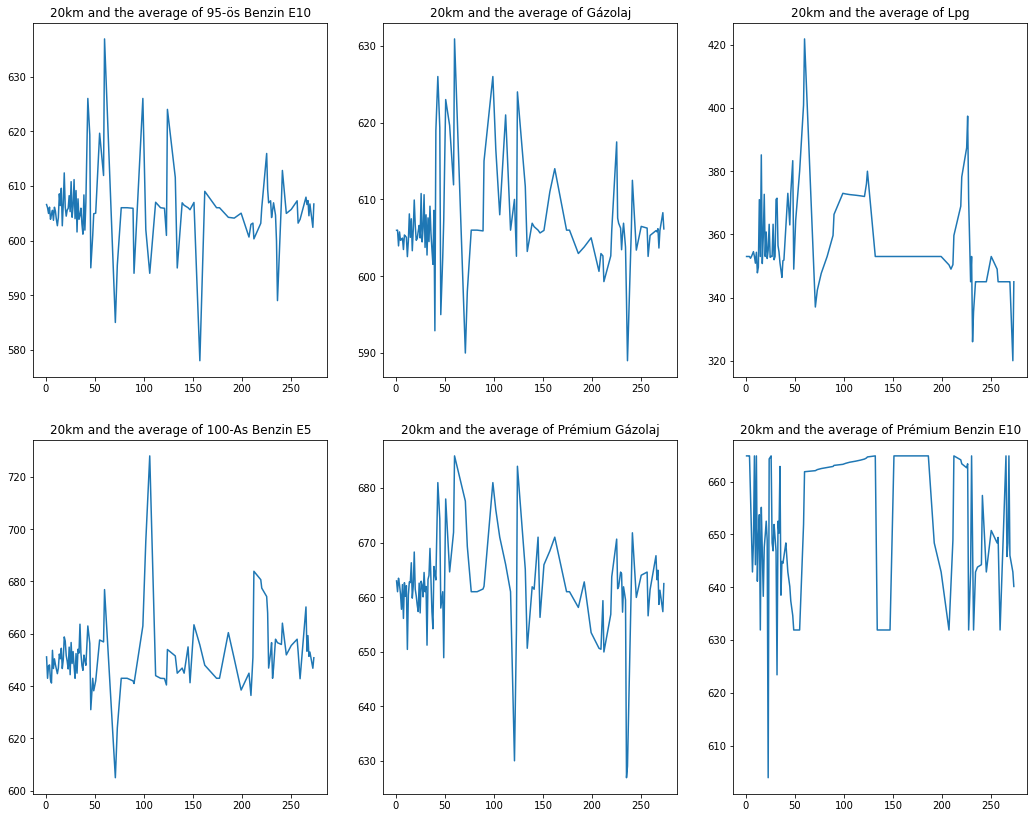

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[3]].sort_values().unique()
y1 = gas_stations.groupby(comp[3])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[3])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[3])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[3])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[3])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[3])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 30 km radius competition price change:

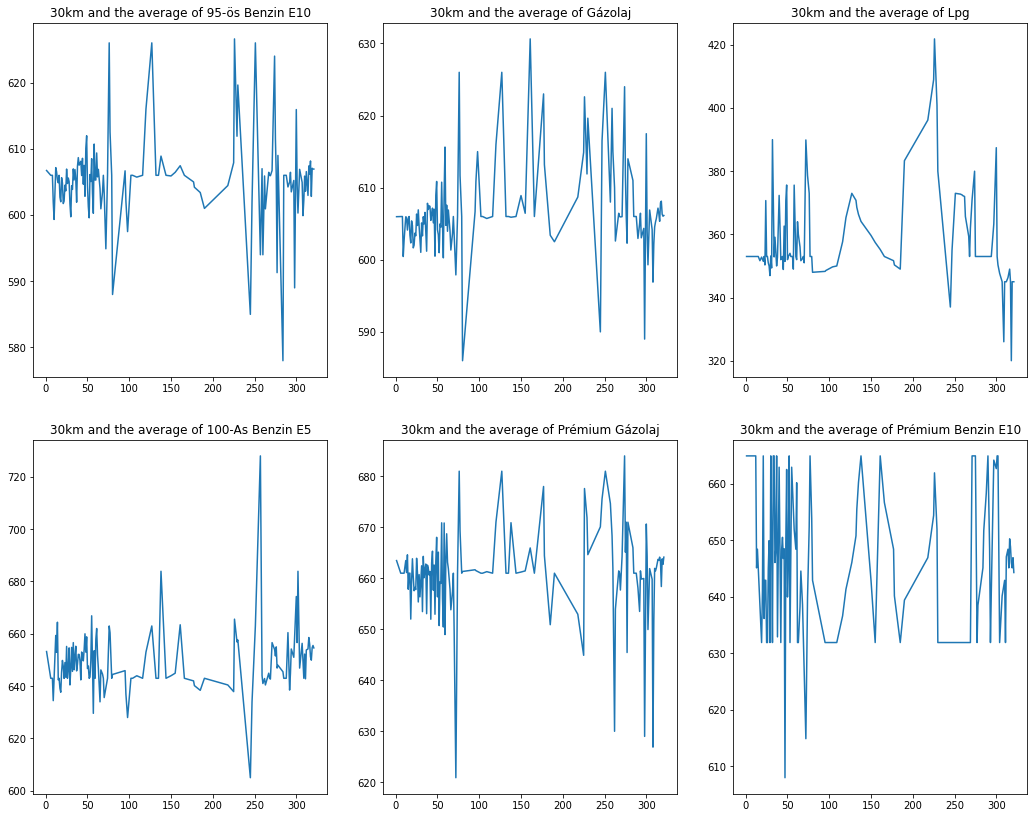

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[4]].sort_values().unique()
y1 = gas_stations.groupby(comp[4])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[4])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[4])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[4])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[4])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[4])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 40 km radius competition price change:

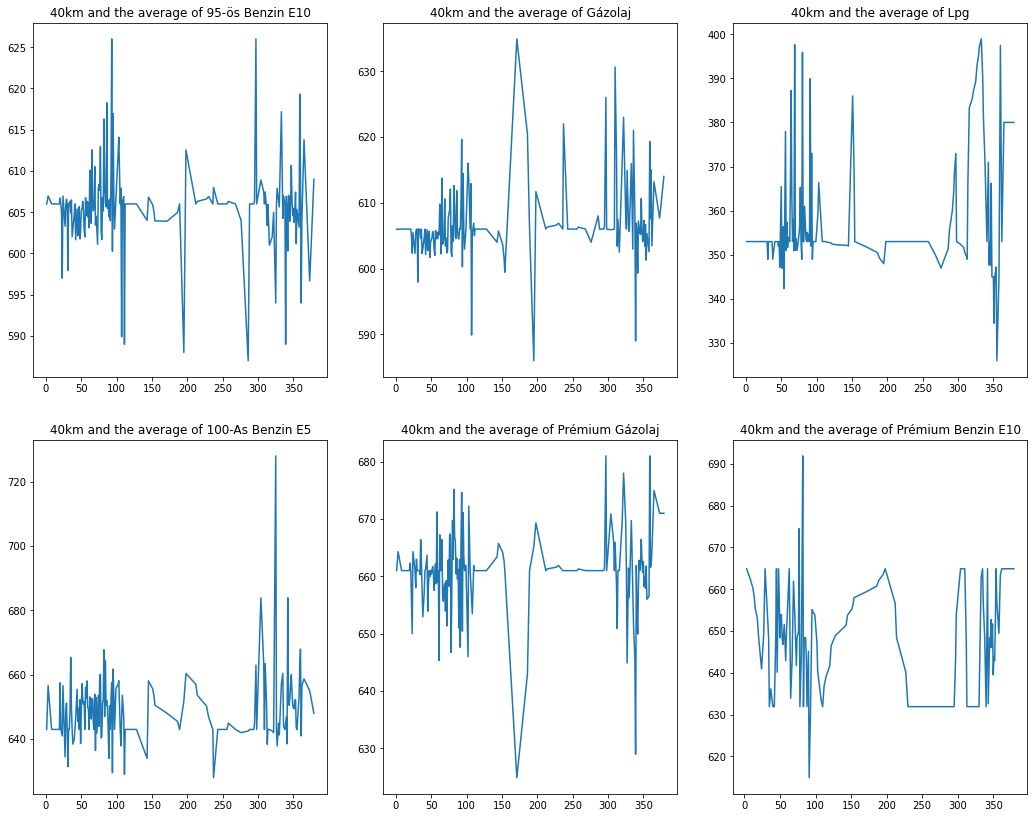

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[5]].sort_values().unique()
y1 = gas_stations.groupby(comp[5])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[5])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[5])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[5])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[5])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[5])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing County (megye in hungarian) Prices:

Check out the following link: https://irányítószámok.cybo.com/magyarorsz%C3%A1g/

In [26]:
def get_region(zip_code):
    if 1011 <= zip_code <= 1806:
        return 'Budapest'
    elif 2000 <= zip_code <= 2769:
        return 'Pest megye'
    elif (2400 <= zip_code <= 2490) or (8000 <= zip_code <= 8157):
        return 'Fejér megye'
    elif (2500 <= zip_code <= 2545) or (2800 <= zip_code <= 2949):
        return 'Komárom-Esztergom megye'
    elif (2640 <= zip_code <= 2699) or (3041 <= zip_code <= 3253):
        return 'Nógrád megye'
    elif (3000 <= zip_code <= 3036) or (3200 <= zip_code <= 3399):
        return 'Heves megye'
    elif 3400 <= zip_code <= 3999:
        return 'Borsod-Abaúj-Zemplén megye'
    elif 4000 <= zip_code <= 4288:
        return 'Hajdú-Bihar megye'
    elif (4300 <= zip_code <= 4977):
        return 'Szabolcs-Szatmár-Bereg megye'
    elif (5000 <= zip_code <= 5476):
        return 'Jász-Nagykun-Szolnok megye'
    elif (5500 <= zip_code <= 5948):
        return 'Békés megye'
    elif (6000 <= zip_code <= 6528):
        return 'Bács-Kiskun megye'
    elif (6600 <= zip_code <= 6932):
        return 'Csongrád vármegye'
    elif (7020 <= zip_code <= 7228):
        return 'Tolna megye'
    elif (7300 <= zip_code <= 7396) or (7600 <= zip_code <= 7985):
        return 'Baranya megye'
    elif (7400 <= zip_code <= 7589) or (8600 <= zip_code <= 8739):
        return 'Somogy vármegye'
    elif 8161 <= zip_code <= 8598:
        return 'Veszprém megye'
    elif (8353 <= zip_code <= 8395) or (8741 <= zip_code <= 8999):
        return 'Zala megye'
    elif 9001 <= zip_code <= 9495:
        return 'Győr-Moson-Sopron megye'
    elif 9500 <= zip_code <= 9985:
        return 'Vas megye'
    else:
        return 'NONE'
    
gas_stations['County'] = gas_stations['Post Code'].apply(get_region)

In [27]:
gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()

/tmp/ipykernel_3770/2733603437.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()


,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
County,,,,,,,,
Baranya megye,605.323810,605.133333,352.491667,650.130556,659.617647,651.342857,NaN,599.000000
Borsod-Abaúj-Zemplén megye,603.610937,603.720312,353.166667,649.548077,659.640909,651.446154,626.666667,594.500000
Budapest,606.220958,606.256886,344.550000,653.602614,662.679739,646.150000,629.000000,599.000000
Bács-Kiskun megye,606.539726,605.545946,351.131034,650.558333,658.129091,646.380000,629.000000,540.460000
Békés megye,604.791429,604.266667,351.988889,648.963636,660.068966,636.275000,NaN,359.900000
Csongrád vármegye,604.082000,603.442000,354.718182,649.478049,656.595349,646.328571,629.000000,372.183333
Fejér megye,606.721212,606.868750,354.846154,653.260000,665.662963,653.800000,629.000000,547.000000
Győr-Moson-Sopron megye,604.288710,605.139063,356.564286,649.002326,663.462500,640.753846,643.000000,505.575000
Hajdú-Bihar megye,606.117021,605.648936,359.666667,647.334884,660.675610,646.566667,629.000000,574.250000


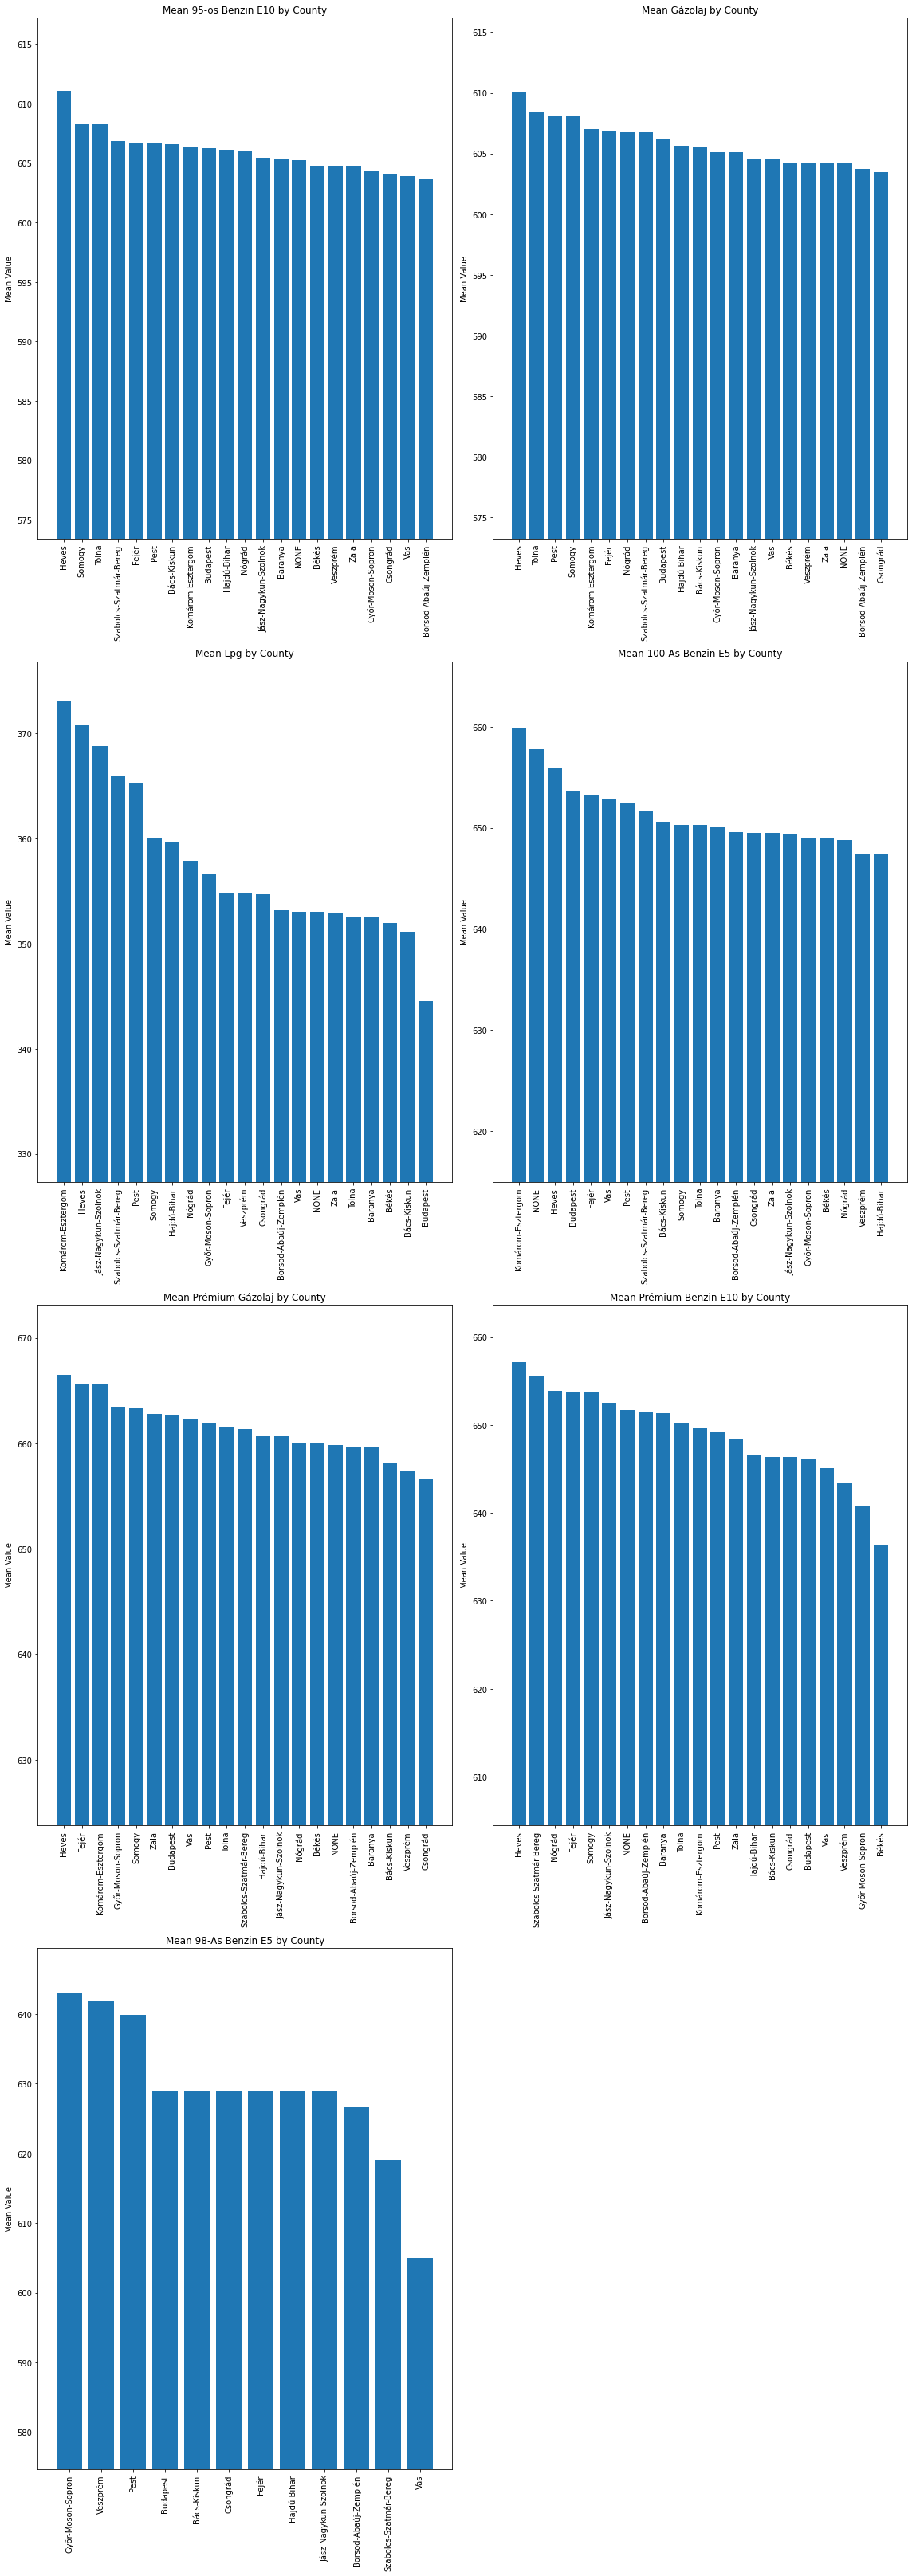

In [28]:
# Group the data by county and calculate the mean of fuel types
fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']
grouped_data = gas_stations.groupby('County')[fuel_types].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 45))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(fuel_types):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)
    # Adjust the y-axis limits to remove extra whitespace
    #ymin, ymax = axs[row, col].get_ylim()
    #axs[row, col].set_ylim(ymin*0.95, ymax*1.2)
    
    # Set the y-axis limits
    axs[row, col].set_ylim(sorted_data[fuel].min() * 0.95, sorted_data[fuel].max()*1.01)

# Remove the extra subplot
fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

In [29]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
print('Average number of competitions based on county:')
gas_stations.groupby('County')[comp].mean()

Average number of competitions based on county:


,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
County,,,,,,
Baranya megye,1.159091,3.545455,8.840909,17.613636,36.386364,60.227273
Borsod-Abaúj-Zemplén megye,2.157143,5.271429,13.257143,25.771429,49.371429,72.442857
Budapest,3.286550,46.269006,134.017544,258.935673,315.578947,348.456140
Bács-Kiskun megye,1.645161,6.956989,9.505376,20.602151,38.075269,70.623656
Békés megye,1.972222,5.250000,7.083333,12.944444,21.444444,40.527778
Csongrád vármegye,2.148148,9.259259,13.425926,26.851852,41.518519,56.629630
Fejér megye,1.076923,10.512821,14.769231,32.410256,64.923077,136.307692
Győr-Moson-Sopron megye,2.200000,10.414286,15.700000,22.471429,38.914286,59.171429
Hajdú-Bihar megye,1.509434,8.188679,9.924528,20.622642,35.886792,60.452830


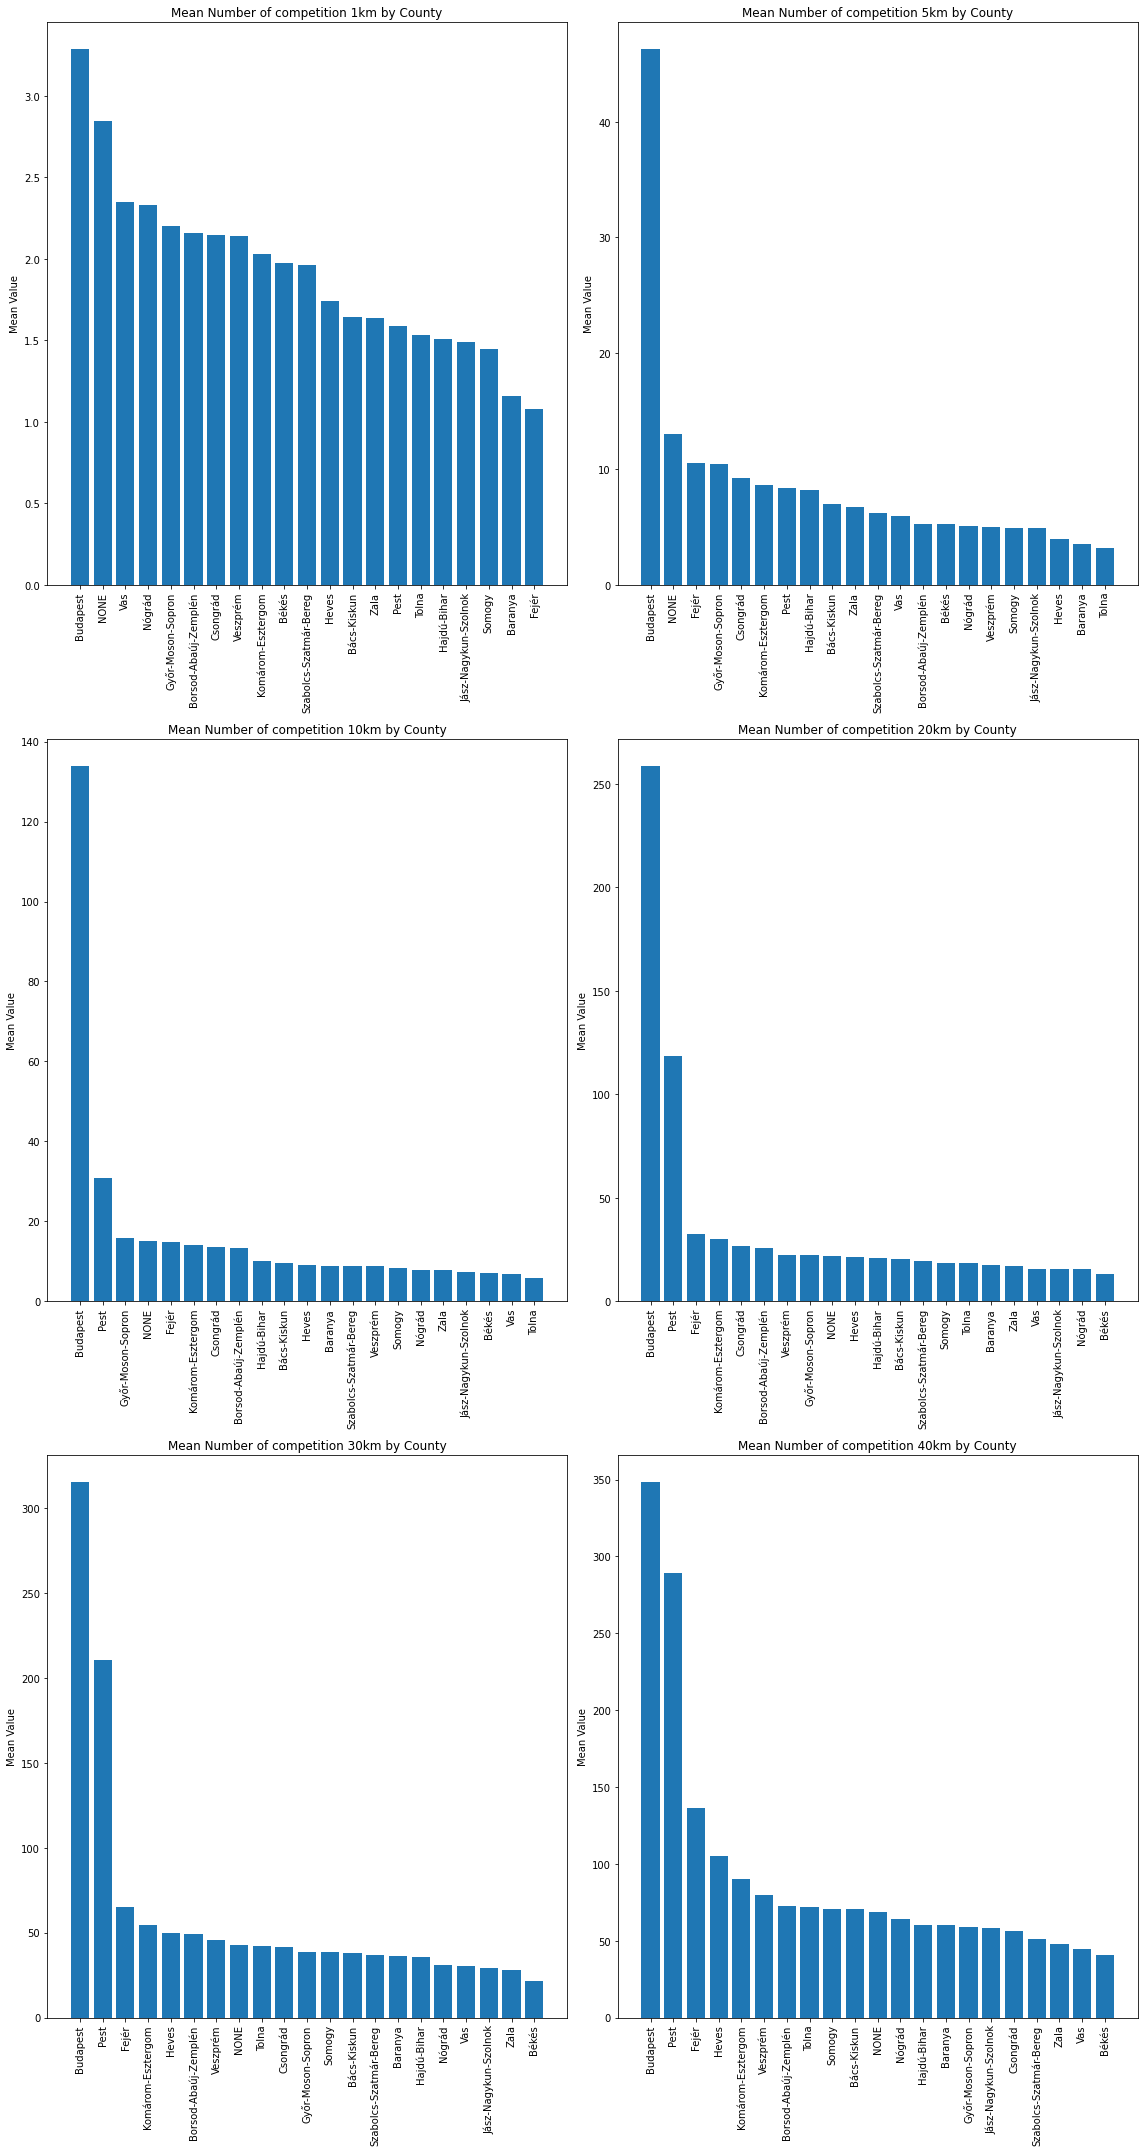

In [32]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
grouped_data = gas_stations.groupby('County')[comp].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(16, 30))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(comp):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)

# Remove the extra subplot
#fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

Let's check out that are the categorical values independent from the newly created County variable.

In [31]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['County'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and County: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and County: 245.80714633778535
P-value: 8.294457196752023e-08


The Chi-square statistic of 245.81 is relatively large, and the very small p-value of 8.29e-08 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between Franchise and County.